In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

# Loading in the dataset

- We use pandas as our main package for data manipulation and analysis
- Dataset has been pre-cleaned in excel:
    - Removed any rows with empty cells
    - Removed uneccessary columns 
        - e.g. Secondary product involvement, secondary victim involvement 
    - Split Product Hazard into its two categories; overall product hazard type, and its specific hazard
    - Changed relevant columns from numerical data to categorical using conversion table provided
        - e.g. For Severity: <br/>
            0 - Death, <br/>
            1 - Hospital Admission, <br/>
            2 - First Aid Received by Non-Medical Professional, <br/>
            3 - No First Aid or Medical Attention Received,<br/>
            4 - Emergency Department Treatment Received,<br/>
            5 - Seen by Medical Professional,<br/>
            6 - Level of care not known,<br/>
            7 - Incident  No Injury

In [2]:
df = pd.read_excel('CPSC Clearinghouse.xlsx')
df.head()

,STATE,INCIDENT YEAR,INCIDENT MONTH,PRODUCT 1,PRODUCT HAZARD TYPE,PRODUCT HAZARD,VICTIM 1 GENDER,VICTIM 1 AGE YEARS,VICTIM 1 INJURY,VICTIM 1 BODY PART,VICTIM 1 SEVERITY,INCIDENT DESCRIPTION
0,SC,2001.0,8.0,Pressure Cookers or Canners (412),Thermal,Hot Liquid or Steam,Female,69,Burn-Scald,Trunk,Hospital Admission,69 YOF WAS COOKING IN PRESSURE COOKER. POT STA...
1,PA,2001.0,9.0,Oven Cleaners (942),Chemical,Poisoning,Female,17,Poisoning,All Parts of the body,Death,28 YOF DECEDENT WHEN SHE WAS 17 YO INGESTED ...
2,MA,2001.0,11.0,Gas Ranges or Ovens (279),Thermal,Hot surface,Female,40,Burn-Thermal,Hand,No First Aid or Medical Attention Received,THE CONSUMER REPORTED SEVERAL ISSUES WITH HER ...
3,CA,2001.0,11.0,Ladders Other or Not Specified (4078),Mechanical,Fall,Male,60,Internal Organ Injury,Head,Death,73 YOM DECEDENT FELL FROM LADDER WHEN HE WAS 6...
4,FL,2001.0,10.0,House Repair or Construction Materials nec (1876),Mechanical,Struck by,Male,45,Other/Not Stated,Unspecified,Death,THE MALE SUBJECT WAS STRUCK BY ROOFING MATERIA...


# Data Wrangling

Data columns are renamed for clarity. 
Furthermore, trailing whitespace in column names was found during modelling, which created errors.

Three types of severity was dropped from our dataset:
- Death
- Level of care not known
- Incident, no injury <br/>
The first being that we are interested in classifying <u>preventable</u> cases into energency and non-emergency. 

In [3]:
#Rename columns for clarity
df.rename({'PRODUCT 1':'PRODUCT', 
           'VICTIM 1 GENDER':'GENDER', 
           'VICTIM 1 AGE YEARS' : 'AGE', 
           'VICTIM 1 INJURY' : 'INJURY',
           'VICTIM 1 BODY PART' : 'BODY PART',
           'VICTIM 1 SEVERITY' : 'SEVERITY'},
            axis=1,
            inplace=True)
df.head()

,STATE,INCIDENT YEAR,INCIDENT MONTH,PRODUCT,PRODUCT HAZARD TYPE,PRODUCT HAZARD,GENDER,AGE,INJURY,BODY PART,SEVERITY,INCIDENT DESCRIPTION
0,SC,2001.0,8.0,Pressure Cookers or Canners (412),Thermal,Hot Liquid or Steam,Female,69,Burn-Scald,Trunk,Hospital Admission,69 YOF WAS COOKING IN PRESSURE COOKER. POT STA...
1,PA,2001.0,9.0,Oven Cleaners (942),Chemical,Poisoning,Female,17,Poisoning,All Parts of the body,Death,28 YOF DECEDENT WHEN SHE WAS 17 YO INGESTED ...
2,MA,2001.0,11.0,Gas Ranges or Ovens (279),Thermal,Hot surface,Female,40,Burn-Thermal,Hand,No First Aid or Medical Attention Received,THE CONSUMER REPORTED SEVERAL ISSUES WITH HER ...
3,CA,2001.0,11.0,Ladders Other or Not Specified (4078),Mechanical,Fall,Male,60,Internal Organ Injury,Head,Death,73 YOM DECEDENT FELL FROM LADDER WHEN HE WAS 6...
4,FL,2001.0,10.0,House Repair or Construction Materials nec (1876),Mechanical,Struck by,Male,45,Other/Not Stated,Unspecified,Death,THE MALE SUBJECT WAS STRUCK BY ROOFING MATERIA...


In [4]:
df['SEVERITY'].value_counts()

Death                                             69029
Hospital Admission                                 5218
First Aid Received by Non-Medical Professional     2813
No First Aid or Medical Attention Received         2595
Emergency Department Treatment Received            2499
Seen by Medical Professional                       1948
Level of care not known                             892
Incident  No Injury                                   1
Name: SEVERITY, dtype: int64

In [5]:
df.drop(df[df.SEVERITY == 'Death'].index, inplace=True)
df.drop(df[df.SEVERITY == 'Level of care not known'].index, inplace=True)
df.drop(df[df.SEVERITY == 'Incident  No Injury'].index, inplace=True)

In [6]:
#Delete trailing whitespace in column names
df.columns = df.columns.str.rstrip()

# Preparation

The dataset is sliced into the independent variables and the dependent variable we are interested in predicting using our model.

The independent variables used are (we are assuming these variables are independent):
- Age, gender, product hazard, injury, and body part

The dependent variable used is:
- Severity 

The independent variables are broken down into dummy variables and normalised.

Finally the subset is split into a test and train set to discourage the model overfitting the data.

In [7]:
#Create dummy variables for independent variables
Feature = df[['AGE']]
columns = df[['GENDER', 'PRODUCT HAZARD', 'INJURY','BODY PART']]
Feature = pd.concat([Feature,pd.get_dummies(columns)], axis=1)
Feature.head()

,AGE,GENDER_Female,GENDER_Male,PRODUCT HAZARD_ Allergenic,PRODUCT HAZARD_ Caustic/Corrosive,PRODUCT HAZARD_ Collision,PRODUCT HAZARD_ Crushing/Pinching,PRODUCT HAZARD_ Electric shock/Electrocution,PRODUCT HAZARD_ Entanglement/Entrapment,PRODUCT HAZARD_ Explosion (pressure related),...,BODY PART_Leg,BODY PART_Mouth,BODY PART_Neck,BODY PART_Not Recorded,BODY PART_Pubic Region,BODY PART_Shoulder (including clavicle collarbone),BODY PART_Toe,BODY PART_Trunk,BODY PART_Unspecified,BODY PART_Wrist
0,69,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,61,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,58,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,8,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [8]:
X = Feature
X = preprocessing.StandardScaler().fit(X).transform(X)

In [9]:
y = df['SEVERITY'].values

In [10]:
#Split dataset into 80% test and 20% train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (12058, 83) (12058,)
Test set: (3015, 83) (3015,)


# ML Algorithms

## K Nearest Neighbor Classification

In [11]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.43548922, 0.42421227, 0.46898839, 0.46832504, 0.48590381,
       0.48822554, 0.49220564, 0.50348259, 0.50149254, 0.50315091,
       0.50149254, 0.50149254, 0.50713101, 0.50315091, 0.50248756,
       0.50547264, 0.50580431, 0.50547264, 0.50414594, 0.50414594,
       0.50746269, 0.50580431, 0.50049751, 0.50381426, 0.50547264,
       0.50414594, 0.50116086, 0.50248756, 0.50149254])

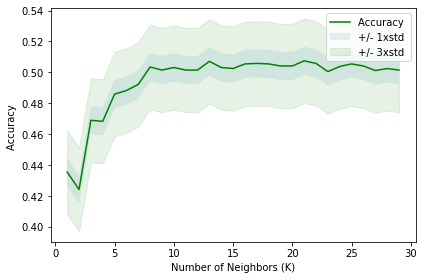

In [12]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [13]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.5074626865671642 with k= 21


## Decision Tree Classification

In [14]:
#Decision Tree Classification
loanTree = DecisionTreeClassifier()
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

['Emergency Department Treatment Received' 'Hospital Admission'
 'Seen by Medical Professional'
 'First Aid Received by Non-Medical Professional' 'Hospital Admission']
['Emergency Department Treatment Received' 'Hospital Admission'
 'No First Aid or Medical Attention Received'
 'Emergency Department Treatment Received'
 'Emergency Department Treatment Received']


In [15]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.45240464344941955


In [16]:
classifier = LogisticRegression(solver='lbfgs', max_iter=10000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.5190713101160862


# Second Attempt

In this attempt we group severity into two groups:
- Medical emergencies that require immediate attention and professional care
    - Hospital admission
    - Emergency department treatment received
- Non emergency injuries that could still require treatment
    - First aid received by non-medical professional
    - No first aid or medical attention received
    - Seen by medical professional

In [17]:
#Group severity into two groups: medical treatment needed vs not needed
df.replace({'Hospital Admission': 'Severe', 
            'First Aid Received by Non-Medical Professional': 'Not severe',
            'No First Aid or Medical Attention Received' : 'Not severe',
            'Emergency Department Treatment Received' : 'Severe',
            'Seen by Medical Professional' : 'Not severe'}, inplace=True)

In [18]:
df.head()

,STATE,INCIDENT YEAR,INCIDENT MONTH,PRODUCT,PRODUCT HAZARD TYPE,PRODUCT HAZARD,GENDER,AGE,INJURY,BODY PART,SEVERITY,INCIDENT DESCRIPTION
0,SC,2001.0,8.0,Pressure Cookers or Canners (412),Thermal,Hot Liquid or Steam,Female,69,Burn-Scald,Trunk,Severe,69 YOF WAS COOKING IN PRESSURE COOKER. POT STA...
2,MA,2001.0,11.0,Gas Ranges or Ovens (279),Thermal,Hot surface,Female,40,Burn-Thermal,Hand,Not severe,THE CONSUMER REPORTED SEVERAL ISSUES WITH HER ...
8,ME,2002.0,1.0,Electric Ranges or Ovens (Excl Counter-top Ove...,Mechanical,Sharp or Pointed Objects,Female,61,Cut,Finger,Not severe,THE CONSUMER STATED THAT SHE NOTICED THAT THE ...
10,MD,2002.0,8.0,Gas Ranges or Ovens (279),Chemical,Caustic/Corrosive,Female,58,Foreign Object Stuck in or on the body,Hand,Not severe,GE GLASS TOP GAS RANGE IS NOT RECALLED HOWEVE...
12,NY,2002.0,1.0,Soccer (Activity Apparel or Equipment) (1267),Mechanical,Projectile/Falling Objects,Female,8,Break Fracture,Leg,Severe,8 YOF SUFFERED CRUSHED FEMUR WHEN PORTABLE SOC...


In [19]:
#Create dummy variables for independent variables
Feature = df[['AGE']]
columns = df[['GENDER', 'PRODUCT HAZARD', 'INJURY','BODY PART']]
Feature = pd.concat([Feature,pd.get_dummies(columns)], axis=1)
Feature.head()

,AGE,GENDER_Female,GENDER_Male,PRODUCT HAZARD_ Allergenic,PRODUCT HAZARD_ Caustic/Corrosive,PRODUCT HAZARD_ Collision,PRODUCT HAZARD_ Crushing/Pinching,PRODUCT HAZARD_ Electric shock/Electrocution,PRODUCT HAZARD_ Entanglement/Entrapment,PRODUCT HAZARD_ Explosion (pressure related),...,BODY PART_Leg,BODY PART_Mouth,BODY PART_Neck,BODY PART_Not Recorded,BODY PART_Pubic Region,BODY PART_Shoulder (including clavicle collarbone),BODY PART_Toe,BODY PART_Trunk,BODY PART_Unspecified,BODY PART_Wrist
0,69,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,61,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,58,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,8,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
X = Feature
X = preprocessing.StandardScaler().fit(X).transform(X)

In [21]:
y = df['SEVERITY'].values

In [22]:
#Split dataset into 80% test and 20% train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (12058, 83) (12058,)
Test set: (3015, 83) (3015,)


# ML Algorithms

## K Nearest Neighbor Classification

In [23]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.75422886, 0.75655058, 0.78606965, 0.7907131 , 0.79502488,
       0.79800995, 0.8       , 0.79701493, 0.80199005, 0.79834163,
       0.80099502, 0.79568823, 0.79966833, 0.79701493, 0.80066335,
       0.80165837, 0.80033167, 0.80298507, 0.80165837, 0.79535655,
       0.80232172, 0.79933665, 0.8026534 , 0.80331675, 0.80331675,
       0.7986733 , 0.80033167, 0.8       , 0.79767828])

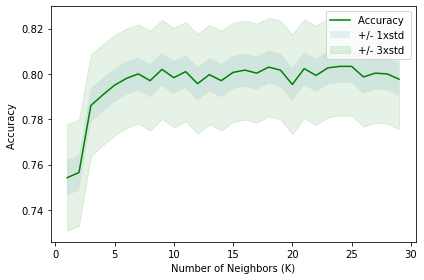

In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [25]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8033167495854063 with k= 24


## Decision Tree Classification

In [26]:
#Decision Tree Classification
loanTree = DecisionTreeClassifier()
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

['Severe' 'Not severe' 'Not severe' 'Not severe' 'Severe']
['Severe' 'Severe' 'Not severe' 'Severe' 'Severe']


In [27]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7655058043117745


## Support Vector Machine

In [28]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat, pos_label='Severe'))

Avg F1-score: 0.8124
Jaccard score: 0.6869


In [29]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat, pos_label='Severe'))

Avg F1-score: 0.7849
Jaccard score: 0.6377


In [30]:
clf3 = svm.SVC(kernel='poly')
clf3.fit(X_train, y_train) 
yhat = clf3.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat, pos_label='Severe'))

Avg F1-score: 0.8117
Jaccard score: 0.6881


In [31]:
clf4 = svm.SVC(kernel='sigmoid')
clf4.fit(X_train, y_train) 
yhat = clf4.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat, pos_label='Severe'))

Avg F1-score: 0.7448
Jaccard score: 0.5996


## Logistic Regression

In [32]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [33]:
yhat = LR.predict(X_test)

In [34]:
print (classification_report(y_test, yhat))
yhat_prob = LR.predict_proba(X_test)
print (jaccard_score(y_test, yhat,pos_label='Severe'))

              precision    recall  f1-score   support

  Not severe       0.78      0.84      0.81      1434
      Severe       0.85      0.78      0.81      1581

    accuracy                           0.81      3015
   macro avg       0.81      0.81      0.81      3015
weighted avg       0.81      0.81      0.81      3015

0.6842105263157895


# Results

## Trial 1

KNN
- The best accuracy was with 0.5074626865671642 with k= 21

Decision Tree
- Accuracy:  0.4540630182421227

## Trial 2

KNN
- The best accuracy was with 0.8033167495854063 with k= 24

Decision Tree
- Accuracy:  0.766832504145937

Support Vector Machine
- Radial basis function kernel (Gaussian):
    - Avg F1-score: 0.8124
- Linear kernel:
    - Avg F1-score: 0.7849
- Polynomial kernel:
    - Avg F1-score: 0.8117
- Sigmoid kernel:
    - Avg F1-score: 0.7448

Logistic Regression
- Avg F1-score: 0.81